In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import plot_tree

# Load data with PANDAS
* TO DO: write the function load() using pandas.read_csv

In [26]:
def load(path):
    return pd.read_csv(path)

TrainXpath="EmberXTrain.csv"
TrainYpath="EmberYTrain.csv"
X=load(TrainXpath)
Y=load(TrainYpath)

# Pre-elaborate data with PANDAS
* For each independent variable analyze the distribution of the values
* Explore the class distribution in Y
* Remove the useless variables

In [27]:
def preElaborationData(X):\

    return X.describe()

description = preElaborationData(X)

In [28]:
def delete_zero_mean_columns(df):
    
    means = preElaborationData(df).loc['mean']
    
    zero_mean_columns = means[means == 0].index
    
    df = df.drop(columns=zero_mean_columns)
    
    return df

X = delete_zero_mean_columns(X)

# Feature evaluation with sklearn

In [29]:
def preBoxPlotAnalysisData(X, Y):
    
    output_directory = 'boxplot'

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    num_columns = len(X.columns)
    for i, column in enumerate(tqdm(X.columns, desc="Progress")):
        data = pd.DataFrame(X[column])
        data['Label'] = Y['Label']

        fig, ax = plt.subplots()
        data.boxplot(by='Label', ax=ax)
        ax.set_title(f'Boxplot for {column}')

        output_path = os.path.join(output_directory, f'boxplot_{column}.png')
        plt.savefig(output_path)
        plt.close()

#preBoxPlotAnalysisData(X, Y)

In [30]:
def mutualInfoRank(X,Y):
    
    seed=42
    np.random.seed(seed)
    print("Computing mutual info ranking...")
    independentList=list(X.columns.values)
    res = dict(zip(independentList,mutual_info_classif(X, np.ravel(Y),discrete_features=False, random_state=seed)))
    sorted_x = sorted(res.items(), key=lambda kv: kv[1], reverse=True)
    print("Computing mutual info ranking...completed")
    return sorted_x

rank=mutualInfoRank(X,Y)
print(rank)

Computing mutual info ranking...
Computing mutual info ranking...completed
[('directories_2355', 0.34468200595838727), ('head_627', 0.3351517763161995), ('directories_2356', 0.32913839267328804), ('section_837', 0.3138364258706954), ('gen_617', 0.31162093000689106), ('section_787', 0.2781273648951521), ('byte_511', 0.27104537979028587), ('byte_509', 0.2702485845587479), ('byte_499', 0.27017901474027317), ('byte_510', 0.26964703490355557), ('byte_512', 0.26843151886172256), ('byte_503', 0.2683192359687421), ('head_686', 0.2680030306027956), ('byte_502', 0.2677204558277211), ('byte_508', 0.2676981194156387), ('byte_507', 0.2670991610051885), ('byte_500', 0.2670256127775097), ('byte_501', 0.26688244537579675), ('byte_504', 0.2666026041661853), ('hist_140', 0.2663814636397459), ('byte_497', 0.26563907518056395), ('byte_506', 0.26350830374861434), ('hist_138', 0.26342256264302244), ('byte_498', 0.2624291254547646), ('hist_232', 0.2618114229365578), ('byte_505', 0.261676750186558), ('hist_23

# Feature selection
* Write the function topFeatureSelect that returns the top features ranked according to MI with MI>=threshold
* To test the function, build XSelected that is the projection of X on the features with MI>=0.1

In [31]:
def topFeatureSelect(rank, threshold):

    selected_features = []

    for feature in rank:
        mi = feature[1]
        if mi>=threshold:
            selected_features.append(feature[0])
    
    return selected_features

# selecting top features
selectedfeatures=topFeatureSelect(rank,0.1)
# create a dataset with the selected features
XSelected=X.loc[:, selectedfeatures]

# PCA
* TO DO: write Python function(s) to learn the principal components of a trainingdata set, in order to create a new data frame projecting the training dataset onboth the top-N principal components and the label
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html check fit() and transform()
1) Note that the principal component model learned on the training set should be also saved to be applied to a possible testing set, when this will be available
2) The PCA is computed on the independent features only

* Write  the  function  pca  that  takes  as  input  a  Dataframe  and  return  the  PCA 
(computed with fit on the Dataframe), the list  of names «pc1», «pc2»,... and the 
list of the explained variance of the PCA object (recorded in 
explained_variance_ratio_)
* Write the function applyPCA that takes as input a Dataframe, a PCA and a list of 
PC names, transform the Dataframe using PCA and create a data frame collecting 
the principal components obtained by using transform of PCA on the Dataframe. 
The  names  of  the  columns  of  the  output    Dataframe  are    the  same  reported  in 
the list of PC names


In [32]:
def pca(df):
    pca = PCA().fit(df)
    pcalist = [f'PC{i+1}' for i in range(len(pca.components_))]
    explained_variance = pca.explained_variance_ratio_
    return pca, pcalist, explained_variance

def applyPCA(df, pca_model, pc_names):
    pcs = pca_model.transform(df)
    pc_df = pd.DataFrame(data=pcs, columns=pc_names)
    return pc_df

pca_model, pcalist, explained_variance = pca(X)
XPCA = applyPCA(X, pca_model, pcalist)


* Write the function NumberOfTopPCSelect that returns the principal
components achieving the sum of variance greater than a threshold
* Test the function by computin XPCASelected

In [33]:
def NumberOfTopPCSelect(explained_variance, threshold):
    total_variance = 0
    num_selected = 0
    
    for variance in explained_variance:
        total_variance += variance
        num_selected += 1
        if total_variance >= threshold:
            break
    
    return num_selected

n=NumberOfTopPCSelect(explained_variance,0.99)
print(n)
# create a dataset with the selected PCs
XPCASelected=XPCA.iloc[:,1:(n+1)]
print(XPCASelected.shape)


5
(12000, 5)


In [34]:
from sklearn.model_selection import StratifiedKFold

def stratifiedKfold(X, y, folds, seed=None):
    # Initialize StratifiedKFold with specified number of folds
    stratified_kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

    # Initialize lists to store training and testing data for each fold
    ListXTrain, ListXTest, ListYTrain, ListYTest = [], [], [], []

    # Iterate through each fold
    for train_index, test_index in stratified_kfold.split(X, y):
        # Split the data into training and testing sets based on the fold indices
        ListXTrain.append(pd.DataFrame(X, index=train_index))
        ListYTrain.append(pd.DataFrame(Y, index=train_index))
        ListXTest.append(pd.DataFrame(X, index=test_index))
        ListYTest.append(pd.DataFrame(Y, index=test_index))

    # Return the lists containing training and testing data for each fold
    return ListXTrain, ListXTest, ListYTrain, ListYTest

# Example usage of the function
folds = 5
seed = 42
ListXTrain, ListXTest, ListYTrain, ListYTest = stratifiedKfold(X, Y, folds, seed)


In [35]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

def decisionTreeLearner(X, y, criterion='gini'):
    clf = DecisionTreeClassifier(criterion=criterion, min_samples_split=500)
    T = clf.fit(X, y)
    return T

def showTree(T):
    plt.figure(figsize=(20, 10))  # Set the figure size
    plot_tree(T, filled=True, rounded=True, feature_names=None, class_names=None)  # Plot the tree
    plt.show()  # Show the plot

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import numpy as np

def determineDecisionTreekFoldConfiguration(ListXTrain, ListYTrain, ListXTest, ListYTest, rank, min_t, max_t, step):

        best_criterion = None
        best_TH = None
        bestN = None
        best_fscore = 0

        criterion = ['gini', 'entropy']

        for criteria in criterion:
            for thre in np.arange(min_t, max_t, step):
                avg_fscore = 0
                fscores = []
                selectedFeatures = topFeatureSelect(rank, thre)
                if (len(selectedFeatures) > 0):
                    for i in range(len(ListXTrain)):
                        x_train_feature_selected = ListXTrain[i].loc[:,selectedFeatures]
                        x_test = ListXTest[i].loc[:, selectedFeatures]
                        clf = decisionTreeLearner(
                            x_train_feature_selected, ListYTrain[i], criteria)

                        y_pred = clf.predict(x_test)
                        fscores.append(f1_score(ListYTest[i], y_pred))

                if (len(fscores) > 1):
                    avg_fscore = np.mean(fscores)
                    print(f"Average F1 score: '{avg_fscore}'")
                    if avg_fscore > best_fscore:
                        best_fscore = avg_fscore
                        best_criterion = criteria
                        best_TH = thre
                        bestN = selectedFeatures

                    if avg_fscore == best_fscore:
                        if (len(selectedFeatures) < len(bestN)):  # Criterio aggiuntivo
                            best_fscore = avg_fscore
                            best_criterion = criteria
                            best_TH = thre
                            bestN = selectedFeatures

            return best_criterion, best_TH, bestN, best_fscore

0.34468200595838727
Average F1 score: '0.8719324680659053'
Average F1 score: '0.8680436409187198'
Average F1 score: '0.8679881337484525'
Average F1 score: '0.8682001112312785'
Average F1 score: '0.8672369640494079'
Average F1 score: '0.8673619603734235'
Average F1 score: '0.8675520274759828'
Average F1 score: '0.8472134539644939'
Average F1 score: '0.8465700147548333'
Average F1 score: '0.8512987380405409'
Average F1 score: '0.848197521571973'
Average F1 score: '0.8464099586596063'
Average F1 score: '0.8219846106065543'
Average F1 score: '0.8298936923868476'
Average F1 score: '0.7874896473901005'
Average F1 score: '0.7874244651628924'
Average F1 score: '0.7486376475843632'
Average F1 score: '0.719033260737769'
Feature Ranking by MI: Best criterion gini best MI threshold 0.0 best N ['directories_2355', 'head_627', 'directories_2356', 'section_837', 'gen_617', 'section_787', 'byte_511', 'byte_509', 'byte_499', 'byte_510', 'byte_512', 'byte_503', 'head_686', 'byte_502', 'byte_508', 'byte_

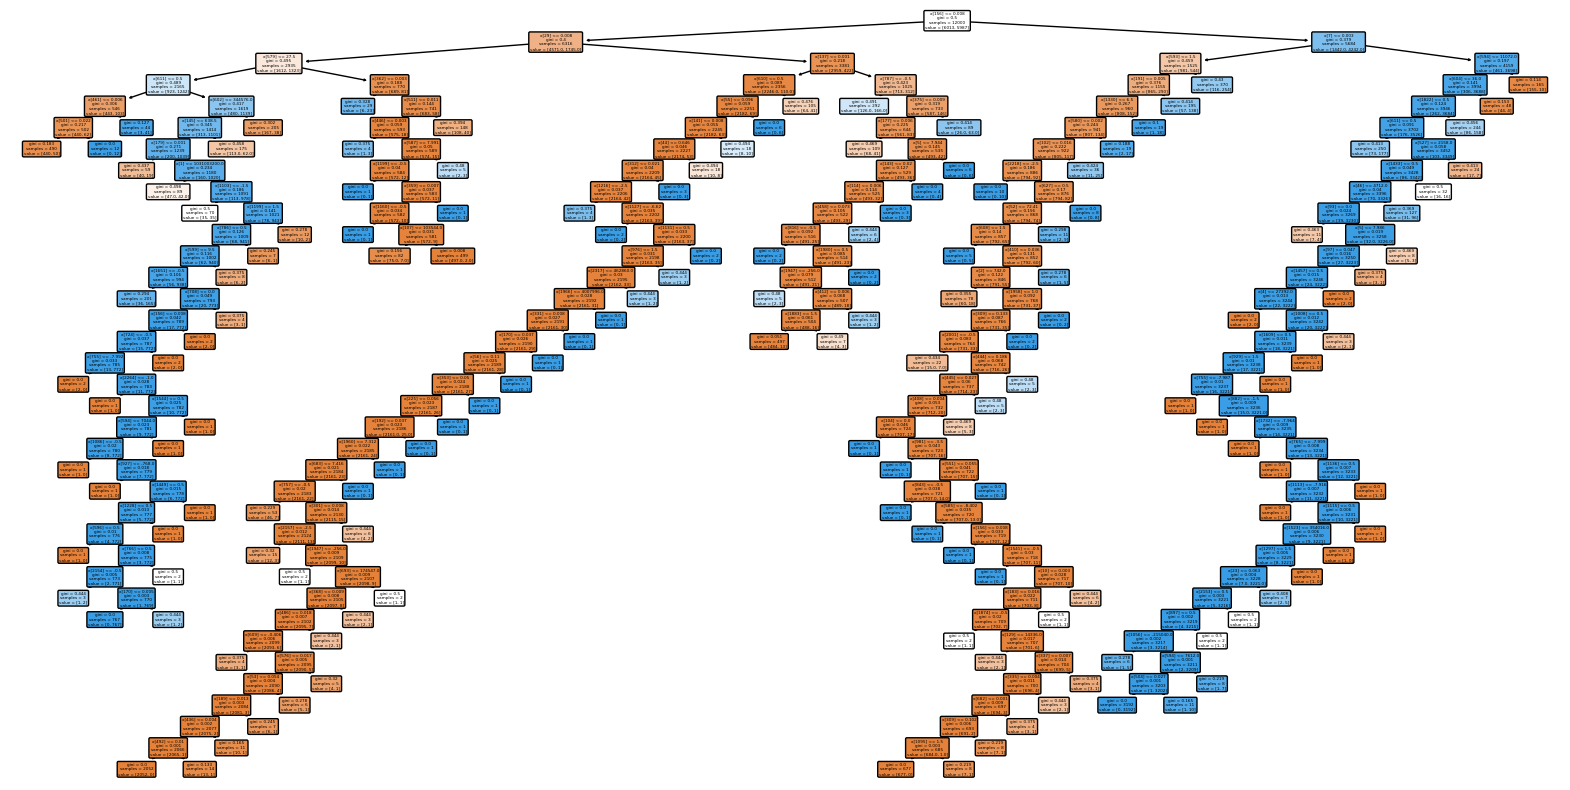

In [37]:
minThreshold=0
max=0.0
for key in rank:
    if (key[1] >= max):
        max=key[1]
print(max)
stepThreshold=0.02
maxThreshold=max+stepThreshold
bestCriterion, bestTH, bestN, bestEval = determineDecisionTreekFoldConfiguration(ListXTrain, ListYTrain, ListXTest, ListYTest, rank, minThreshold, maxThreshold, stepThreshold)
print('Feature Ranking by MI:','Best criterion',bestCriterion, 'best MI threshold', bestTH, 'best N', bestN, 'Best CV F',bestEval)
toplist = topFeatureSelect(rank, bestTH)
DT=decisionTreeLearner(X.loc[:, toplist],Y,bestCriterion)
showTree(DT)

In [38]:
def determineDecisionTreekFoldConfigurationPCA(ListXTrain, ListYTrain, ListXTest, ListYTest, explained_variance, min_t, max_t, step):
        best_criterionPCA = None
        bestTHPCA = None
        bestNPCA = None
        bestEvalPCA = 0

        criterion = ['gini', 'entropy']

        for criteria in criterion:
            for thre in np.arange(min_t, max_t, step):
                avg_fscore = 0
                fscores = []
                n = NumberOfTopPCSelect(explained_variance, thre)
                if (n > 0):
                    # Utilizzo la lunghezza di ListXTrain poichè è la stessa di ListXTest
                    for i in range(len(ListXTrain)):
                        # indicizzazione di tipo :n in Python seleziona gli elementi dall’indice 0 all’indice n-1
                        x_train_feature_selected = ListXTrain[i].iloc[:, :n]
                        x_test = ListXTest[i].iloc[:, :n]
                        """
                        x_test = ListXTest[i].iloc[:, 1:(
                            n+1)]
                        """
                        clf = decisionTreeLearner(
                            x_train_feature_selected, ListYTrain[i], criteria)

                        y_pred = clf.predict(x_test)
                        fscores.append(f1_score(ListYTest[i], y_pred))

                if (len(fscores) > 1):
                    avg_fscore = np.mean(fscores)
                    print(f"Average F1 score: '{avg_fscore}'")
                    if avg_fscore > bestEvalPCA:
                        bestEvalPCA = avg_fscore
                        best_criterionPCA = criteria
                        bestTHPCA = thre
                        bestNPCA = n

                    if avg_fscore == bestEvalPCA:
                        if (n < bestNPCA):
                            bestEvalPCA = avg_fscore
                            best_criterionPCA = criteria
                            bestTHPCA = thre
                            bestNPCA = n

            # Salva le variabili in un dizionario
            BestConfiguration = {"best_criterionPCA": best_criterionPCA, "bestTHPCA": bestTHPCA,
                                "bestNPCA": bestNPCA, "bestEvalPCA": bestEvalPCA, }


            return best_criterionPCA, bestTHPCA, bestNPCA, bestEvalPCA

In [39]:
pca_model, pcalist, explained_variance = pca(X)
XPCA = applyPCA(X, pca_model, pcalist)

Average F1 score: '0.7629656829371276'
Average F1 score: '0.7629656829371276'
Average F1 score: '0.7690372912618647'
Average F1 score: '0.7690372912618647'
Average F1 score: '0.7758345933720346'
Average F1 score: '0.8214202403388334'
Average F1 score: '0.8207021853665244'
Feature Ranking by MI: Best criterion gini best MI threshold 1.0 best N ['directories_2355', 'head_627', 'directories_2356', 'section_837', 'gen_617', 'section_787', 'byte_511', 'byte_509', 'byte_499', 'byte_510', 'byte_512', 'byte_503', 'head_686', 'byte_502', 'byte_508', 'byte_507', 'byte_500', 'byte_501', 'byte_504', 'hist_140', 'byte_497', 'byte_506', 'hist_138', 'byte_498', 'hist_232', 'byte_505', 'hist_233', 'hist_117', 'hist_175', 'hist_2', 'hist_172', 'hist_144', 'hist_142', 'hist_167', 'string_522', 'byte_473', 'string_612', 'byte_477', 'hist_159', 'hist_171', 'string_521', 'byte_408', 'byte_492', 'byte_401', 'hist_1', 'hist_170', 'string_513', 'hist_106', 'hist_192', 'hist_174', 'hist_5', 'byte_469', 'string

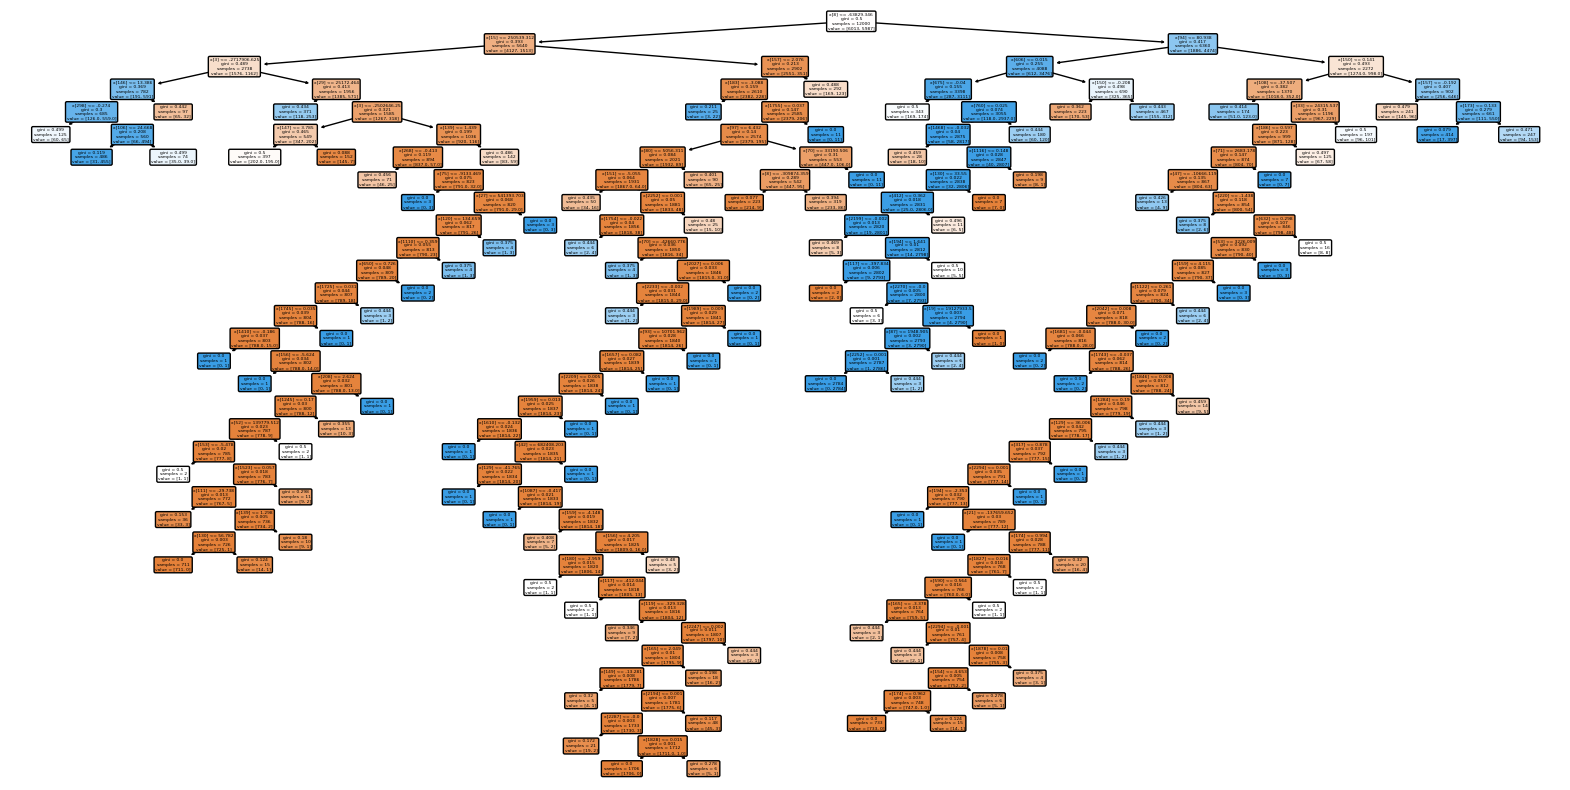

In [40]:
minThreshold=0.95
stepThreshold=0.01
maxThreshold=1.01
ListXTrainPCA,ListXTestPCA,ListYTrainPCA,ListYTestPCA=stratifiedKfold(XPCA,Y,folds)
bestCriterionPCA, bestTH, bestNPCA, bestEval=determineDecisionTreekFoldConfigurationPCA(ListXTrainPCA,ListYTrainPCA,ListXTestPCA,ListYTestPCA,explained_variance, minThreshold,maxThreshold,stepThreshold)
print('Feature Ranking by MI:','Best criterion',bestCriterion, 'best MI threshold', bestTH, 'best N', bestN, 'Best CV F',bestEval)
DTPCA=decisionTreeLearner(XPCA.iloc[:, 1:(bestNPCA + 1)],Y,bestCriterionPCA)
showTree(DTPCA)

In [41]:
TestXpath="EmberXTest.csv"
TestYpath="EmberYTest.csv"
X_pred=load(TestXpath)
Y_pred=load(TestYpath)